In [2]:
import sys
sys.path.append('..')

import optimus
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import numpy as np
from optimus.source.transducers import transducer_field
from optimus.postprocess.plot import surface_plot

In [3]:
loaded_arr = np.loadtxt("MUSCLE_IPP_abs.txt")

IPP_abs = loaded_arr.reshape(
    loaded_arr.shape[0], loaded_arr.shape[1] // 201, 201)

frequency = 500e3 # 1MHz
a = 0.003 #3cm
D = 0.18 #18 cm
centroid_file='Data/default_random_array_centroid_locations.dat'
source = optimus.source.create_array(frequency, element_radius=a, centroid_locations_filename=centroid_file,
                                     location=[-D, 0, 0], number_of_point_sources_per_wavelength=2, velocity=0.4)

sphere_radius = 7.5e-3
geometry = optimus.geometry.shapes.Sphere(radius=7.5e-3, element_size=0.75e-3)
material_ext = optimus.material.load_material('muscle') #CAMBIE A MUSCULO POR ALPLA MUY BAJO EN WATER
material_int = optimus.material.load_material('bone (cortical)')

x = source.centroid_locations[0, :]
y = source.centroid_locations[1, :]
z = source.centroid_locations[2, :]

Nx = 201
Ny = 101
Nz = 101

xmin, xmax, ymin, ymax, zmin, zmax = [-D, D, -0.05, 0.05, -0.05, 0.05]

In [4]:
c_0 = material_ext.speed_of_sound #bien
rho_0 = material_ext.density #bien
C_t = material_ext.heat_capacity 
k_t = material_ext.thermal_conductivity
eta = material_ext.attenuation_pow_b 
alpha_0 = material_ext.attenuation_coeff_a # Np/m
#alpha_0 = material_ext.attenuation_coeff_a * 8.69 # dB/m

I = (IPP_abs)**2 / (c_0 * rho_0)
alpha = alpha_0 * frequency / 1000000
Q = I.copy()
Q = 2 * alpha * I

delta_x = (xmax - xmin) / Nx
delta_y = (ymax - ymin) / Ny
delta_z = (zmax - zmin) / Nz

Q = 2 * alpha * I
bordes_x = 50 #queda de 2*bordes_x+1
bordes_y = 25
Q_copy = Q.copy()

Q = [corte[51-bordes_y: 51+bordes_y+1, 101-bordes_x: 101+bordes_x+1] for corte in Q_copy]
Q = Q[51-bordes_y: 51+bordes_y+1]
Q = np.array(Q)

In [5]:
def pulso_rect(t, pd = 2e-3, pri = 4e-3):
    
    t_pulso = np.remainder(t, pri)
    indicator = t_pulso < pd
    amplitud = np.zeros_like(t)
    amplitud[indicator] = 1
    
    return amplitud

def pulso_turk(t, pd = 3.25e-3, pri = 4e-3, rd = 1e-3):
    
    t_pulso = np.remainder(t, pri)
    
    indicator_1 = t_pulso < rd
    indicator_2 = np.logical_and(t_pulso < pd - rd, t_pulso >= rd)
    indicator_3 = np.logical_and(t_pulso >= pd - rd, t_pulso < pd)
    
    amplitud = np.zeros_like(t)
    amplitud[indicator_2] = 1
    #amplitud[indicator_1] = np.sin(np.pi * (2 * t_pulso[indicator_1] - rd) / (2 * rd)) / 2 + 0.5
    amplitud[indicator_1] = -np.cos(np.pi * (t_pulso[indicator_1] / rd)) / 2 + 0.5
    #amplitud[indicator_3] = np.sin(np.pi / 2 + np.pi * (t_pulso[indicator_3] - pd + rd) / rd) / 2 + 0.5
    amplitud[indicator_3] = -np.cos(np.pi * ((t_pulso[indicator_3] - pd) / rd)) / 2 + 0.5
    
    return amplitud

In [6]:
Nx = 2 * bordes_x + 1
Ny = 2 * bordes_y + 1
Nz = Ny

t_0 = 37
T_0 = np.zeros_like(Q) + t_0

def next_it_numpy_am(T, Q, am): #Se agrega amortiguador al cuadrado
    
    T_ret = np.zeros_like(T) + t_0
    A = 1 - 2 * delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2) + delta_y ** (-2) + delta_z ** (-2))
    B = delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2))
    C = delta_t * k_t / (rho_0 * C_t) * (delta_y ** (-2))
    D = delta_t * k_t / (rho_0 * C_t) * (delta_z ** (-2))
    E = delta_t / (rho_0 * C_t)
    T_ret[1:Nz-1, 1:Ny-1, 1:Nx-1] = (Q[1:Nz-1, 1:Ny-1, 1:Nx-1] * E * am * am + 
                             T[1:Nz-1, 1:Ny-1, 1:Nx-1] * A +
                             (T[1:Nz-1, 1:Ny-1, 0:Nx-2] + T[1:Nz-1, 1:Ny-1, 2:Nx]) * B + 
                             (T[1:Nz-1, 0:Ny-2, 1:Nx-1] + T[1:Nz-1, 2:Ny, 1:Nx-1]) * C +
                             (T[0:Nz-2, 1:Ny-1, 1:Nx-1] + T[2:Nz, 1:Ny-1, 1:Nx-1]) * D
                        )
    return T_ret

In [7]:
np.shape(Q)

(51, 51, 101)

In [11]:
x, y ,z = np.shape(Q)

In [13]:
c_0, rho_0, C_t, k_t

(1588.4305555555557, 1090.4, 3421.2, 0.49496875000000007)

# Integrales

Área de un pulso turk: $pd-rd$. Área de un pulso turk cuadrado: $pd-\frac{5}{4}rd$. El valor de la integral coincide en ambos pulsos del paper al tomar el cuadrado.

# Cambiar pulsos

In [14]:
delta_t = 2e-5
Nt = int(3e4)

t_ramp = []
t_rect = []
t_noam = []

T_ramp = T_0
T_rect = T_0
T_noam = T_0

tiempos = np.array(range(Nt)) * delta_t
pulsos_rect = pulso_rect(tiempos)
pulsos_ramp = pulso_turk(tiempos)

In [25]:
%%time
for i in range(Nt):
    t_ramp.append(np.max(T_ramp))
    t_rect.append(np.max(T_rect))
    t_noam.append(np.max(T_noam))
    
    T_ramp = next_it_numpy_am(T_ramp, Q, pulsos_ramp[i])
    T_rect = next_it_numpy_am(T_rect, Q, pulsos_rect[i])
    T_noam = next_it_numpy_am(T_noam, Q, 1)

CPU times: user 13min 42s, sys: 36 ms, total: 13min 42s
Wall time: 13min 42s


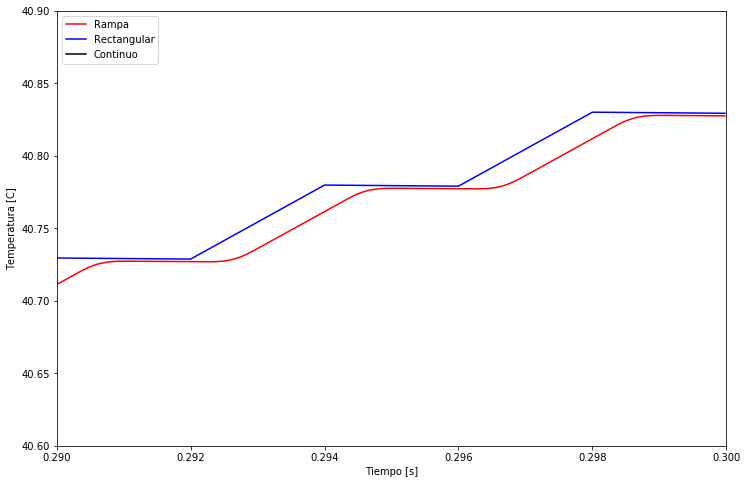

In [58]:
fig = plt.figure(figsize = (12,8))

plt.plot(tiempos, t_ramp, c='red', label = 'Rampa')
plt.plot(tiempos, t_rect, c='blue', label = 'Rectangular')
plt.plot(tiempos, t_noam, c='black', label = 'Continuo')

plt.legend(loc = 'upper left')
plt.xlim(0.29, 0.3)
plt.ylim(40.6, 40.9)
plt.xlabel('Tiempo [s]')
plt.ylabel('Temperatura [C]')
plt.show()

In [49]:
t_ramp[200]-t_ramp[100]

0.016440222480888167

In [59]:
t_ramp[-1]

40.82759090082562

In [60]:
t_rect[-1]

40.82939060297481

In [51]:
tiempos[200]

0.004

In [33]:
delta_t = 2e-5
Nt = int(1.5e4)

#tiempos
tiempos = np.array(range(Nt)) * delta_t

- Probar sacar temperatura en un solo punto (foco) y en máximo.
- Buscar xq se deja pulso descansar.
- Limpiar notebook. Hacer uno con tiempos muy largos y converger. Otro con diferencia entre 3 funciones. Ambos notebook llaman a misma función next it. Todo en inglés.
- Ir formando notebook final.
- Usar numpy doc. Ver librería black.